# Named Entity Recognition on French CV

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
from __future__ import print_function
from collections import OrderedDict

import torch
import torch.nn as nn
from torch.nn import init
from torch.autograd import Variable
from torch import autograd
from torch.optim.lr_scheduler import StepLR

import time
import _pickle as cPickle

import urllib
import matplotlib.pyplot as plt

import os
import sys
import codecs
import re
import numpy as np

In [ ]:
os.chdir('drive/MyDrive/Code NER CV')

##### Define constants and paramaters

In [ ]:
#parameters for the Model
parameters = OrderedDict()
parameters['train'] = "data/train.conllu" #Path to train file
parameters['test'] = "data/test.conllu" #Path to test file
parameters['tag_scheme'] = "BIO"
parameters['lower'] = True # Boolean variable to control lowercasing of words
parameters['zeros'] =  True # Boolean variable to control replacement of  all digits by 0 
parameters['char_dim'] = 30 #Char embedding dimension
parameters['word_dim'] = 300 #Word embedding dimension
parameters['word_lstm_dim'] = 200 #Token LSTM hidden layer size
parameters['embedding_path'] = "wiki.multi.fr.vec.txt" #Path to pretrained embeddings
parameters['dropout'] = 0.5 
parameters['epoch'] =  50 #Number of epochs to run"
parameters['weights'] = "" #path to Pretrained for from a previous run
parameters['name'] = "self-trained-model-CV" # Model name
parameters['gradient_clip']=5.0
models_path = "./models/" #path to saved models

#GPU
parameters['use_gpu'] = torch.cuda.is_available() #GPU Check
use_gpu = parameters['use_gpu']

parameters['reload'] = "./models/self-trained-model-CV" 

#Constants
START_TAG = '<START>'
STOP_TAG = '<STOP>'

In [ ]:
#To stored model
name = parameters['name']
model_name = models_path + name #get_name(parameters)

if not os.path.exists(models_path):
    os.makedirs(models_path)

### Load Wikineural dataset

In [ ]:
!pip install conllu

In [ ]:
from conllu import parse as conllu_parse

def store_sentences(path_data):
    sentences = []
    with open(path_data, encoding='utf-8') as reader:
        lines = conllu_parse(reader.read())
    for line in lines :
        sentence = []
        for i in range(len(line)) :
            word = []            
            word.append(line[i]["form"])
            word.append(line[i]["lemma"])
            sentence.append(word)
        sentences.append(sentence)
    return sentences

In [ ]:
train_sentences = store_sentences(parameters['train'])

test_sentences = store_sentences(parameters['test'])
val_sentences = list(reversed(test_sentences))

##### Create Mappings for Words, Characters and Tags

In [ ]:
def create_dico(item_list):
    """
    Create a dictionary of items from a list of list of items.
    """
    assert type(item_list) is list
    dico = {}
    for items in item_list:
        for item in items:
            if item not in dico:
                dico[item] = 1
            else:
                dico[item] += 1
    return dico

def create_mapping(dico):
    """
    Create a mapping (item to ID / ID to item) from a dictionary.
    Items are ordered by decreasing frequency.
    """
    sorted_items = sorted(dico.items(), key=lambda x: (-x[1], x[0]))
    id_to_item = {i: v[0] for i, v in enumerate(sorted_items)}
    item_to_id = {v: k for k, v in id_to_item.items()}
    return item_to_id, id_to_item

def word_mapping(sentences, lower):
    """
    Create a dictionary and a mapping of words, sorted by frequency.
    """
    words = [[x[0].lower() if lower else x[0] for x in s] for s in sentences]
    dico = create_dico(words)
    dico['<UNK>'] = 10000000 #UNK tag for unknown words
    word_to_id, id_to_word = create_mapping(dico)
    print("Found %i unique words (%i in total)" % (
        len(dico), sum(len(x) for x in words)
    ))
    return dico, word_to_id, id_to_word

def char_mapping(sentences):
    """
    Create a dictionary and mapping of characters, sorted by frequency.
    """
    chars = ["".join([w[0] for w in s]) for s in sentences]
    dico = create_dico(chars)
    char_to_id, id_to_char = create_mapping(dico)
    print("Found %i unique characters" % len(dico))
    return dico, char_to_id, id_to_char

def tag_mapping(sentences):
    """
    Create a dictionary and a mapping of tags, sorted by frequency.
    """
    tags = [[word[-1] for word in s] for s in sentences]
    dico = create_dico(tags)
    dico[START_TAG] = -1
    dico[STOP_TAG] = -2
    tag_to_id, id_to_tag = create_mapping(dico)
    print("Found %i unique named entity tags" % len(dico))
    return dico, tag_to_id, id_to_tag

In [ ]:
dico_words, word_to_id, id_to_word = word_mapping(train_sentences, parameters['lower'])
dico_chars, char_to_id, id_to_char = char_mapping(train_sentences)
dico_tags, tag_to_id, id_to_tag = tag_mapping(train_sentences)

Found 101205 unique words (2601959 in total)
Found 544 unique characters
Found 11 unique named entity tags


In [ ]:
dico_tags

{'<START>': -1,
 '<STOP>': -2,
 'B-LOC': 80323,
 'B-MISC': 22896,
 'B-ORG': 18382,
 'B-PER': 61780,
 'I-LOC': 23731,
 'I-MISC': 36388,
 'I-ORG': 23090,
 'I-PER': 60102,
 'O': 2275267}

In [ ]:
tag_to_id

{'<START>': 9,
 '<STOP>': 10,
 'B-LOC': 1,
 'B-MISC': 7,
 'B-ORG': 8,
 'B-PER': 2,
 'I-LOC': 5,
 'I-MISC': 4,
 'I-ORG': 6,
 'I-PER': 3,
 'O': 0}

##### Preparing final dataset

In [ ]:
def lower_case(x,lower=False):
    if lower:
        return x.lower()  
    else:
        return x

In [ ]:
def prepare_dataset(sentences, word_to_id, char_to_id, tag_to_id, lower=False):
    """
    Prepare the dataset. Return a list of lists of dictionaries containing:
        - word indexes
        - word char indexes
        - tag indexes
    """
    data = []
    for s in sentences:    
        #Get the words of the sentence and store them in a list
        str_words = [w[0] for w in s]
        #Get the id of each word
        words_id = [word_to_id[lower_case(w,lower) if lower_case(w,lower) in word_to_id else '<UNK>']
                 for w in str_words]
        #Get the character mapping of each word
        chars = [[char_to_id[c] for c in w if c in char_to_id]
                 for w in str_words]
        #Get the tag associated to each word
        tags = [tag_to_id[w[-1]] for w in s]
        data.append({
            'str_words': str_words,
            'words_id': words_id,
            'chars': chars,
            'tags': tags,
        })

    return data

train_data = prepare_dataset(
    train_sentences, word_to_id, char_to_id, tag_to_id, parameters['lower']
)

val_data = prepare_dataset(
    val_sentences, word_to_id, char_to_id, tag_to_id, parameters['lower']
)

test_data = prepare_dataset(
    test_sentences, word_to_id, char_to_id, tag_to_id, parameters['lower']
)

##### Load Word Embeddings

The Embeddings have been pretrained on a French wikipedia corpus

In [ ]:
#Store all the embeddings in a dict
all_word_embeds = {}
for i, line in enumerate(codecs.open(parameters['embedding_path'], 'r', 'utf-8')):
    s = line.strip().split()
    if len(s) == parameters['word_dim'] + 1:
        all_word_embeds[s[0]] = np.array([float(i) for i in s[1:]])

#Intializing Word Embedding Matrix. Allows to have a random embedding for words we don't have pre-trained embedding
word_embeds = np.random.uniform(-np.sqrt(3/parameters['word_dim']), np.sqrt(3/parameters['word_dim']), (len(word_to_id), parameters['word_dim']))

#Compute the embedding of every word in the training set
for w in word_to_id:
    if w in all_word_embeds:
        word_embeds[word_to_id[w]] = all_word_embeds[w]
    elif w.lower() in all_word_embeds:
        word_embeds[word_to_id[w]] = all_word_embeds[w.lower()]

print('Loaded %i pretrained embeddings.' % len(all_word_embeds))

Loaded 199041 pretrained embeddings.


### Model


##### Initialization


In [ ]:
def init_embedding(input_embedding):
    """
    Initialize embedding
    """
    bias = np.sqrt(3.0 / input_embedding.size(1))
    nn.init.uniform_(input_embedding, -bias, bias)

In [ ]:
def init_linear(input_linear):
    """
    Initialize linear transformation
    """
    bias = np.sqrt(6.0 / (input_linear.weight.size(0) + input_linear.weight.size(1)))
    nn.init.uniform_(input_linear.weight, -bias, bias)
    if input_linear.bias is not None:
        input_linear.bias.data.zero_()

In [ ]:
def init_lstm(input_lstm):
    """
    Initialize lstm          
    """
    
    # Weights init for forward layer
    for ind in range(0, input_lstm.num_layers):
        
        ## Gets the weights Tensor from our model, for the input-hidden weights in our current layer
        weight = eval('input_lstm.weight_ih_l' + str(ind))
        
        # Initialize the sampling range
        sampling_range = np.sqrt(6.0 / (weight.size(0) / 4 + weight.size(1)))
        
        # Randomly sample from our samping range using uniform distribution and apply it to our current layer
        nn.init.uniform_(weight, -sampling_range, sampling_range)
        
        # Similar to above but for the hidden-hidden weights of the current layer
        weight = eval('input_lstm.weight_hh_l' + str(ind))
        sampling_range = np.sqrt(6.0 / (weight.size(0) / 4 + weight.size(1)))
        nn.init.uniform_(weight, -sampling_range, sampling_range)
        
        
    # We do the above again, for the backward layer if we are using a bi-directional LSTM (our final model uses this)
    if input_lstm.bidirectional:
        for ind in range(0, input_lstm.num_layers):
            weight = eval('input_lstm.weight_ih_l' + str(ind) + '_reverse')
            sampling_range = np.sqrt(6.0 / (weight.size(0) / 4 + weight.size(1)))
            nn.init.uniform_(weight, -sampling_range, sampling_range)
            weight = eval('input_lstm.weight_hh_l' + str(ind) + '_reverse')
            sampling_range = np.sqrt(6.0 / (weight.size(0) / 4 + weight.size(1)))
            nn.init.uniform_(weight, -sampling_range, sampling_range)

    # Bias initialization steps
    
    # We initialize them to zero except for the forget gate bias, which is initialized to 1
    if input_lstm.bias:
        for ind in range(0, input_lstm.num_layers):
            bias = eval('input_lstm.bias_ih_l' + str(ind))
            
            # Initializing to zero
            bias.data.zero_()
            
            # This is the range of indices for our forget gates for each LSTM cell
            bias.data[input_lstm.hidden_size: 2 * input_lstm.hidden_size] = 1
            
            #Similar for the hidden-hidden layer
            bias = eval('input_lstm.bias_hh_l' + str(ind))
            bias.data.zero_()
            bias.data[input_lstm.hidden_size: 2 * input_lstm.hidden_size] = 1
            
        # Similar to above, we do for backward layer if we are using a bi-directional LSTM 
        for ind in range(0, input_lstm.num_layers):
            bias = eval('input_lstm.bias_ih_l' + str(ind) + '_reverse')
            bias.data.zero_()
            bias.data[input_lstm.hidden_size: 2 * input_lstm.hidden_size] = 1
            bias = eval('input_lstm.bias_hh_l' + str(ind) + '_reverse')
            bias.data.zero_()
            bias.data[input_lstm.hidden_size: 2 * input_lstm.hidden_size] = 1

## CRF

Implement a CRF from scratch is difficult, we found help from https://pytorch.org/tutorials/beginner/nlp/advanced_tutorial.html)

##### Helper Functions

In [ ]:
def log_sum_exp(vec):
    '''
    This function calculates the score explained above for the forward algorithm
    vec 2D: 1 * tagset_size
    '''
    max_score = vec[0, argmax(vec)]
    max_score_broadcast = max_score.view(1, -1).expand(1, vec.size()[1])
    return max_score + torch.log(torch.sum(torch.exp(vec - max_score_broadcast)))
    
def argmax(vec):
    '''
    This function returns the max index in a vector
    '''
    _, idx = torch.max(vec, 1)
    return to_scalar(idx)

def to_scalar(var):
    '''
    Function to convert pytorch tensor to a scalar
    '''
    return var.view(-1).data.tolist()[0]

In [ ]:
def score_sentences(self, feats, tags):
    # tags is ground_truth, a list of ints, length is len(sentence)
    # feats is a 2D tensor, len(sentence) * tagset_size
    r = torch.LongTensor(range(feats.size()[0]))
    if self.use_gpu:
        r = r.cuda()
        pad_start_tags = torch.cat([torch.cuda.LongTensor([self.tag_to_ix[START_TAG]]), tags])
        pad_stop_tags = torch.cat([tags, torch.cuda.LongTensor([self.tag_to_ix[STOP_TAG]])])
    else:
        pad_start_tags = torch.cat([torch.LongTensor([self.tag_to_ix[START_TAG]]), tags])
        pad_stop_tags = torch.cat([tags, torch.LongTensor([self.tag_to_ix[STOP_TAG]])])

    score = torch.sum(self.transitions[pad_stop_tags, pad_start_tags]) + torch.sum(feats[r, tags])

    return score

##### Implementation of Forward Algorithm

In [ ]:
def forward_alg(self, feats):
    '''
    This function performs the forward algorithm explained above
    '''
    # calculate in log domain
    # feats is len(sentence) * tagset_size
    # initialize alpha with a Tensor with values all equal to -10000.
    
    # Do the forward algorithm to compute the partition function
    init_alphas = torch.Tensor(1, self.tagset_size).fill_(-10000.)
    
    # START_TAG has all of the score.
    init_alphas[0][self.tag_to_ix[START_TAG]] = 0.
    
    # Wrap in a variable so that we will get automatic backprop
    forward_var = autograd.Variable(init_alphas)
    if self.use_gpu:
        forward_var = forward_var.cuda()
        
    # Iterate through the sentence
    for feat in feats:
        # broadcast the emission score: it is the same regardless of
        # the previous tag
        emit_score = feat.view(-1, 1)
        
        # the ith entry of trans_score is the score of transitioning to
        # next_tag from i
        tag_var = forward_var + self.transitions + emit_score
        
        # The ith entry of next_tag_var is the value for the
        # edge (i -> next_tag) before we do log-sum-exp
        max_tag_var, _ = torch.max(tag_var, dim=1)
        
        # The forward variable for this tag is log-sum-exp of all the
        # scores.
        tag_var = tag_var - max_tag_var.view(-1, 1)
        
        # Compute log sum exp in a numerically stable way for the forward algorithm
        forward_var = max_tag_var + torch.log(torch.sum(torch.exp(tag_var), dim=1)).view(1, -1) # ).view(1, -1)
    terminal_var = (forward_var + self.transitions[self.tag_to_ix[STOP_TAG]]).view(1, -1)
    alpha = log_sum_exp(terminal_var)
    # Z(x)
    return alpha

##### Implementation of Viterbi Algorithm

In [ ]:
def viterbi_algo(self, feats):
    '''
    In this function, we implement the viterbi algorithm explained above.
    A Dynamic programming based approach to find the best tag sequence
    '''
    backpointers = []
    # analogous to forward
    
    # Initialize the viterbi variables in log space
    init_vvars = torch.Tensor(1, self.tagset_size).fill_(-10000.)
    init_vvars[0][self.tag_to_ix[START_TAG]] = 0
    
    # forward_var at step i holds the viterbi variables for step i-1
    forward_var = Variable(init_vvars)
    if self.use_gpu:
        forward_var = forward_var.cuda()
    for feat in feats:
        next_tag_var = forward_var.view(1, -1).expand(self.tagset_size, self.tagset_size) + self.transitions
        _, bptrs_t = torch.max(next_tag_var, dim=1)
        bptrs_t = bptrs_t.squeeze().data.cpu().numpy() # holds the backpointers for this step
        next_tag_var = next_tag_var.data.cpu().numpy() 
        viterbivars_t = next_tag_var[range(len(bptrs_t)), bptrs_t] # holds the viterbi variables for this step
        viterbivars_t = Variable(torch.FloatTensor(viterbivars_t))
        if self.use_gpu:
            viterbivars_t = viterbivars_t.cuda()
            
        # Now add in the emission scores, and assign forward_var to the set
        # of viterbi variables we just computed
        forward_var = viterbivars_t + feat
        backpointers.append(bptrs_t)

    # Transition to STOP_TAG
    terminal_var = forward_var + self.transitions[self.tag_to_ix[STOP_TAG]]
    terminal_var.data[self.tag_to_ix[STOP_TAG]] = -10000.
    terminal_var.data[self.tag_to_ix[START_TAG]] = -10000.
    best_tag_id = argmax(terminal_var.unsqueeze(0))
    path_score = terminal_var[best_tag_id]
    
    # Follow the back pointers to decode the best path.
    best_path = [best_tag_id]
    for bptrs_t in reversed(backpointers):
        best_tag_id = bptrs_t[best_tag_id]
        best_path.append(best_tag_id)
        
    # Pop off the start tag (we dont want to return that to the caller)
    start = best_path.pop()
    assert start == self.tag_to_ix[START_TAG] # Sanity check
    best_path.reverse()
    return path_score, best_path

In [ ]:
def forward_calc(self, sentence, chars, chars2_length, d):
    
    '''
    The function calls viterbi decode and generates the 
    most probable sequence of tags for the sentence
    '''
    
    # Get the emission scores from the BiLSTM
    feats = self._get_lstm_features(sentence, chars, chars2_length, d)
    # viterbi to get tag_seq
    
    # Find the best path, given the features.
    score, tag_seq = self.viterbi_decode(feats)


    return score, tag_seq

### Model

In [ ]:
def get_lstm_features(self, sentence, chars2, chars2_length, d):    
    
    chars_embeds = self.char_embeds(chars2).unsqueeze(1)
    #CNN
    chars_cnn_out3 = self.char_cnn3(chars_embeds)
    chars_embeds = nn.functional.max_pool2d(chars_cnn_out3,
                                         kernel_size=(chars_cnn_out3.size(2), 1)).view(chars_cnn_out3.size(0), self.out_channels)
    ## Loading word embeddings
    embeds = self.word_embeds(sentence)
    

    ## We concatenate the word embeddings and the character level representation
    embeds = torch.cat((embeds, chars_embeds), 1)

    embeds = embeds.unsqueeze(1)

    ## Dropout
    embeds = self.dropout(embeds)

    ## Word bilstm
    lstm_out, _ = self.lstm(embeds)

    ## Reshaping the outputs from the lstm layer
    lstm_out = lstm_out.view(len(sentence), self.hidden_dim*2)

    ## Dropout on the lstm output
    lstm_out = self.dropout(lstm_out)

    ## Linear layer converts the ouput vectors to tag space
    lstm_feats = self.hidden2tag(lstm_out)
    
    return lstm_feats

In [ ]:
def get_neg_log_likelihood(self, sentence, tags, chars2, chars2_length, d):
    # sentence, tags is a list of ints
    # features is a 2D tensor, len(sentence) * self.tagset_size
    feats = self._get_lstm_features(sentence, chars2, chars2_length, d)
    forward_score = self._forward_alg(feats)
    gold_score = self._score_sentence(feats, tags)
    return forward_score - gold_score

##### Main Model Class

In [ ]:
class BiLSTM_CRF(nn.Module):

    def __init__(self, vocab_size, tag_to_ix, embedding_dim, hidden_dim,
                 char_to_ix=None, pre_word_embeds=None, char_out_dimension=25,char_embedding_dim=25, use_gpu=False
                 ):
        '''
        Input parameters:                
                vocab_size= Size of vocabulary (int)
                tag_to_ix = Dictionary that maps NER tags to indices
                embedding_dim = Dimension of word embeddings (int)
                hidden_dim = The hidden dimension of the LSTM layer (int)
                char_to_ix = Dictionary that maps characters to indices
                pre_word_embeds = Numpy array which provides mapping from word embeddings to word indices
                char_out_dimension = Output dimension from the CNN encoder for character
                char_embedding_dim = Dimension of the character embeddings
                use_gpu = defines availability of GPU 
        '''
        
        super(BiLSTM_CRF, self).__init__()
        
        #parameter initialization for the model
        self.use_gpu = use_gpu
        self.embedding_dim = embedding_dim
        self.hidden_dim = hidden_dim
        self.vocab_size = vocab_size
        self.tag_to_ix = tag_to_ix
        self.tagset_size = len(tag_to_ix)
        self.out_channels = char_out_dimension

        if char_embedding_dim is not None:
            self.char_embedding_dim = char_embedding_dim
            
            #Initializing the character embedding layer
            self.char_embeds = nn.Embedding(len(char_to_ix), char_embedding_dim)
            init_embedding(self.char_embeds.weight)          

                
            #Performing CNN encoding on the character embeddings            
            self.char_cnn3 = nn.Conv2d(in_channels=1, out_channels=self.out_channels, kernel_size=(3, char_embedding_dim), padding=(2,0))

        #Creating Embedding layer with dimension of ( number of words * dimension of each word)
        self.word_embeds = nn.Embedding(vocab_size, embedding_dim)
        if pre_word_embeds is not None:
            #Initializes the word embeddings with pretrained word embeddings
            self.pre_word_embeds = True
            self.word_embeds.weight = nn.Parameter(torch.FloatTensor(pre_word_embeds))
        else:
            self.pre_word_embeds = False
    
        #Initializing the dropout layer, with dropout specificed in parameters
        self.dropout = nn.Dropout(parameters['dropout'])       

        self.lstm = nn.LSTM(embedding_dim+self.out_channels, hidden_dim, bidirectional=True)
        
        #Initializing the lstm layer using predefined function for initialization
        init_lstm(self.lstm)
        
        # Linear layer which maps the output of the bidirectional LSTM into tag space.
        self.hidden2tag = nn.Linear(hidden_dim*2, self.tagset_size)
        
        #Initializing the linear layer using predefined function for initialization
        init_linear(self.hidden2tag) 

        # Matrix of transition parameters.  Entry i,j is the score of transitioning *to* i *from* j.
        # Matrix has a dimension of (total number of tags * total number of tags)
        self.transitions = nn.Parameter(
            torch.zeros(self.tagset_size, self.tagset_size))

        # These two statements enforce the constraint that we never transfer
        # to the start tag and we never transfer from the stop tag
        self.transitions.data[tag_to_ix[START_TAG], :] = -10000
        self.transitions.data[:, tag_to_ix[STOP_TAG]] = -10000

    #assigning the functions, which we have defined earlier
    _score_sentence = score_sentences
    _get_lstm_features = get_lstm_features
    _forward_alg = forward_alg
    viterbi_decode = viterbi_algo
    neg_log_likelihood = get_neg_log_likelihood
    forward = forward_calc

In [ ]:
#creating the model using the Class defined above
model = BiLSTM_CRF(vocab_size=len(word_to_id),
                   tag_to_ix=tag_to_id,
                   embedding_dim=parameters['word_dim'],
                   hidden_dim=parameters['word_lstm_dim'],
                   use_gpu=use_gpu,
                   char_to_ix=char_to_id,
                   pre_word_embeds=word_embeds)
print('model initialized')

model initialized


In [ ]:
if use_gpu:
    model.cuda()

##### Training Paramaters

In [ ]:
learning_rate = 0.015
momentum = 0.9
number_of_epochs = parameters['epoch'] 
gradient_clip = parameters['gradient_clip']
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=momentum)
scheduler = StepLR(optimizer, step_size=10, gamma=0.1)

#variables which will used in training process
losses = [] #list to store all losses
best_val_F = -1.0 # Current best F-1 Score on Validation Set
best_test_F = -1.0 # Current best F-1 Score on Test Set
best_train_F = -1.0 # Current best F-1 Score on Train Set
count = 0 #Counts the number of iterations
trigger_times = 0
patience = 10

### Evaluation

##### Helper functions for evaluation

In [ ]:
def get_chunk_type(tok, idx_to_tag):
    """
    The function takes in a chunk ("B-PER") and then splits it into the tag (PER) and its class (B)
    as defined in BIOES
    
    Args:
        tok: id of token, ex 4
        idx_to_tag: dictionary {4: "B-PER", ...}

    Returns:
        tuple: "B", "PER"

    """
    tag_name = idx_to_tag[tok]
    tag_class = tag_name.split('-')[0]
    tag_type = tag_name.split('-')[-1]
    return tag_class, tag_type

In [ ]:
def get_chunks(seq, tags):
    """Given a sequence of tags, group entities and their position

    Args:
        seq: [4, 4, 0, 0, ...] sequence of labels
        tags: dict["O"] = 4

    Returns:
        list of (chunk_type, chunk_start, chunk_end)

    Example:
        seq = [4, 5, 0, 3]
        tags = {"B-PER": 4, "I-PER": 5, "B-LOC": 3}
        result = [("PER", 0, 2), ("LOC", 3, 4)]

    """
    
    # We assume by default the tags lie outside a named entity
    default = tags["O"]
    
    idx_to_tag = {idx: tag for tag, idx in tags.items()}
    chunks = []
    
    chunk_type, chunk_start = None, None
    for i, tok in enumerate(seq):
        # End of a chunk 1
        if tok == default and chunk_type is not None:
            # Add a chunk.
            chunk = (chunk_type, chunk_start, i)
            chunks.append(chunk)
            chunk_type, chunk_start = None, None

        # End of a chunk + start of a chunk!
        elif tok != default:
            tok_chunk_class, tok_chunk_type = get_chunk_type(tok, idx_to_tag)
            if chunk_type is None:
                # Initialize chunk for each entity
                chunk_type, chunk_start = tok_chunk_type, i
            elif tok_chunk_type != chunk_type or tok_chunk_class == "B":
                # If chunk class is B, i.e., its a beginning of a new named entity
                # or, if the chunk type is different from the previous one, then we
                # start labelling it as a new entity
                chunk = (chunk_type, chunk_start, i)
                chunks.append(chunk)
                chunk_type, chunk_start = tok_chunk_type, i
        else:
            pass

    # end condition
    if chunk_type is not None:
        chunk = (chunk_type, chunk_start, len(seq))
        chunks.append(chunk)

    return chunks

In [ ]:
def evaluating(model, datas, best_F, tag_to_id, dataset="Validation"):
    '''
    The function takes as input the model, data and calcuates F-1 Score
    It performs conditional updates 
     1) Flag to save the model 
     2) Best F-1 score
    ,if the F-1 score calculated improves on the previous F-1 score
    '''
    # Initializations
    prediction = [] # A list that stores predicted tags
    save = False # Flag that tells us if the model needs to be saved
    new_F = 0.0 # Variable to store the current F1-Score (may not be the best)
    correct_preds, total_correct, total_preds = 0., 0., 0. # Count variables
    
    for data in datas:
        ground_truth_id = data['tags']
        words = data['str_words']
        chars2 = data['chars']      

        d = {}
        # Padding the each word to max word size of that sentence
        chars2_length = [len(c) for c in chars2]
        char_maxl = max(chars2_length)
        chars2_mask = np.zeros((len(chars2_length), char_maxl), dtype='int')
        for i, c in enumerate(chars2):
            chars2_mask[i, :chars2_length[i]] = c
        chars2_mask = Variable(torch.LongTensor(chars2_mask))

        dwords = Variable(torch.LongTensor(data['words_id']))
        
        # We are getting the predicted output from our model
        if use_gpu:
            val,out = model(dwords.cuda(), chars2_mask.cuda(), chars2_length, d)
        else:
            val,out = model(dwords, chars2_mask, chars2_length, d)
        predicted_id = out
    
        
        # We use the get chunks function defined above to get the true chunks
        # and the predicted chunks from true labels and predicted labels respectively
        lab_chunks      = set(get_chunks(ground_truth_id,tag_to_id))
        lab_pred_chunks = set(get_chunks(predicted_id,
                                         tag_to_id))

        # Updating the count variables
        correct_preds += len(lab_chunks & lab_pred_chunks)
        total_preds   += len(lab_pred_chunks)
        total_correct += len(lab_chunks)
    
    # Calculating the F1-Score
    p   = correct_preds / total_preds if correct_preds > 0 else 0
    r   = correct_preds / total_correct if correct_preds > 0 else 0
    new_F  = 2 * p * r / (p + r) if correct_preds > 0 else 0

    
    # If our current F1-Score is better than the previous best, we update the best
    # to current F1 and we set the flag to indicate that we need to checkpoint this model
    
    if new_F>best_F:
        best_F=new_F
        save=True
        
    print("{}: new_F: {} best_F: {} ".format(dataset,new_F,best_F))


    return best_F, new_F, save

### Training Step

In [ ]:
count = 0
F_train = []
F_val = []
model.train(True)
for epoch in range(1,number_of_epochs):
    loss = 0.0
    print('epoch',epoch)
    for i, index in enumerate(np.random.permutation(len(train_data))):
        if (i%1000==0):
          print(i,'/',len(train_data))
        count += 1
        data = train_data[index]

        ##gradient updates for each data entry
        model.zero_grad()

        sentence_in = data['words_id']
        sentence_in = Variable(torch.LongTensor(sentence_in))
        tags = data['tags']
        chars2 = data['chars']
        d = {}

        ## Padding the each word to max word size of that sentence
        chars2_length = [len(c) for c in chars2]
        char_maxl = max(chars2_length)
        chars2_mask = np.zeros((len(chars2_length), char_maxl), dtype='int')
        for i, c in enumerate(chars2):
            chars2_mask[i, :chars2_length[i]] = c
        chars2_mask = Variable(torch.LongTensor(chars2_mask))


        targets = torch.LongTensor(tags)
        #we calculate the negative log-likelihood for the predicted tags using the predefined function
        if use_gpu:
            neg_log_likelihood = model.neg_log_likelihood(sentence_in.cuda(), targets.cuda(), chars2_mask.cuda(), chars2_length, d)
        else:
            neg_log_likelihood = model.neg_log_likelihood(sentence_in, targets, chars2_mask, chars2_length, d)
        loss += neg_log_likelihood.item() / len(data['words_id'])

        neg_log_likelihood.backward()

        #we use gradient clipping to avoid exploding gradients
        torch.nn.utils.clip_grad_norm_(model.parameters(), gradient_clip)
        optimizer.step()
    
    
    #Evaluating on Validation dataset
    model.train(False)

    #Compute Fscore on training data
    _, new_train_F, _ =  evaluating(model, train_data, 1 , tag_to_id, "Training")
    best_val_F, new_val_F, save = evaluating(model, val_data, best_val_F, tag_to_id, "Validation")

    scheduler.step()

    #if the F-score on the validation set is greater than the best previous F-score, then we save the loadings
    if save:
        print("Saving Model to ", model_name)
        torch.save(model.state_dict(), model_name)
        trigger_times = 0
    model.train(True)
    F_train.append(new_train_F)
    F_val.append(new_val_F)
    losses.append(loss)
    
    
    if new_val_F < best_val_F:
        trigger_times += 1
        print('trigger times:', trigger_times)

    if trigger_times >= patience:
        print('Early stopping!')
        break
        
    


epoch 1
0 / 10000
1000 / 10000
2000 / 10000
3000 / 10000
4000 / 10000
5000 / 10000
6000 / 10000
7000 / 10000
8000 / 10000
9000 / 10000
Training: new_F: 0.8567582417582418 best_F: 1 
Validation: new_F: 0.8180876172931898 best_F: 0.8180876172931898 
Saving Model to  ./models/self-trained-model-CV
epoch 2
0 / 10000
1000 / 10000
2000 / 10000
3000 / 10000
4000 / 10000
5000 / 10000
6000 / 10000
7000 / 10000
8000 / 10000
9000 / 10000
Training: new_F: 0.9290221247325805 best_F: 1 
Validation: new_F: 0.8541242937853107 best_F: 0.8541242937853107 
Saving Model to  ./models/self-trained-model-CV
epoch 3
0 / 10000
1000 / 10000
2000 / 10000
3000 / 10000
4000 / 10000
5000 / 10000
6000 / 10000
7000 / 10000
8000 / 10000
9000 / 10000
Training: new_F: 0.9550951328037561 best_F: 1 
Validation: new_F: 0.8635471483430521 best_F: 0.8635471483430521 
Saving Model to  ./models/self-trained-model-CV
epoch 4
0 / 10000
1000 / 10000
2000 / 10000
3000 / 10000
4000 / 10000
5000 / 10000
6000 / 10000
7000 / 10000
800

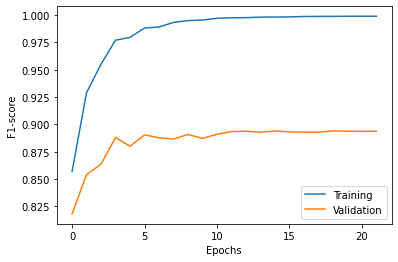

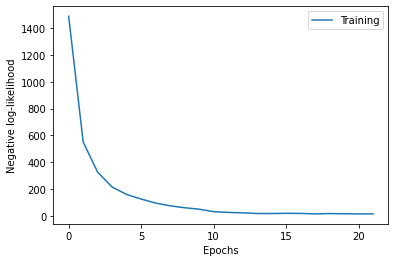

In [ ]:
fig = plt.figure()

plt.plot(F_train,label='Training')
plt.plot(F_val,label='Validation')
plt.xlabel('Epochs')
plt.ylabel('F1-score')
plt.legend()
plt.show()
fig.savefig('F1.png')


plt.plot(losses,label='Training')
plt.xlabel('Epochs')
plt.ylabel('Negative log-likelihood')
plt.legend()
plt.show()
fig.savefig('loss.png')



### Model Testing

In [ ]:
#Reload a saved model, if parameter["reload"] is set to a path
if parameters['reload']:
    model.load_state_dict(torch.load(parameters['reload'], map_location=torch.device('cpu')))
    print("model reloaded :", parameters['reload'])

if use_gpu:
    model.cuda()

model reloaded : ./models/self-trained-model-CV


In [ ]:
_, new_train_F, _ =  evaluating(model, train_data, 1 , tag_to_id, "Training")
_, new_val_F, _ =  evaluating(model, val_data, 1 , tag_to_id, "Validation")
_, new_test_F, _ =  evaluating(model, test_data, 1 , tag_to_id, "Test")



Training: new_F: 0.9937891597581329 best_F: 1 
Validation: new_F: 0.8762666973744818 best_F: 1 
Test: new_F: 0.8767303512183959 best_F: 1 


# Fine-tuning on CV

Load CV

In [ ]:
def tag_to_BIO(label):
    '''
    Transforms the tag scheme of a dictionnary of tag [name entity : tag]

    Input parameters : 
        label : (str) last element of a tag [begin_tag, end_tag, label]
    
    Output :
        new_label : (str) label adapted to the BIO tag scheme
    '''

    new_label = label
    if label.startswith('U'):
        label_tmp = list(label)
        label_tmp[0] = 'B'
        new_label = ''.join(label_tmp)
    if label.startswith('L'):
        label_tmp = list(label)
        label_tmp[0] = 'I'
        new_label = ''.join(label_tmp)
       
        
    return new_label

In [ ]:
import json

def load_CV(path, text_key, label_key):
    '''
    Loads a jsonl file
    
    Input parameters : 
        path : (str) path of the jsonl file
        text_key : (str) key corresponding to the text of a CV in jsonl file
        label_key : (str) key corresponding to the labels of a CV in jsonl file
    
    Output :
        train_sentences : (list) containing the text of a CV
        tags : (list) containing the tags of a CV
    '''
    train_sentences =[]
    tags = []
    with open(path, 'r', encoding='utf8') as json_file:
        json_list = list(json_file)


    for json_str in json_list:
        #Each json_str corresponds to 1 CV
        load = json.loads(json_str)
        text = load[text_key]
        tags.append(load[label_key])
        train_sentences.append(text)
    
    #Apply the tag_to_BIO to each label 
    for tag in tags:
        for t in tag :
            label = t[-1]
            #print(label)
            t[-1] = tag_to_BIO(label)
            if t[-1] == 'B-DateExp' or t[-1] == 'I-DateExp':        
                t[-1] = 'O'
    return train_sentences, tags


In [ ]:
skills_data, tags_skills = load_CV('../NER annoté/cv_remy_skills360.jsonl', 'text', 'labels')

Create a dictionary storing a tag mapping for the tags of skills

In [ ]:
def create_dico_tags(tags):
    #Store labels in a list
    list_label = []
    for tag in tags :
        for t in tag:
            label = t[-1]
            if label not in list_label:
                list_label.append(label)

    #To be sure O has the value 0 because it was the case in the original training but don't know if useful or not
    dico_label = {'O' : 10000000, '<START>': -1,
     '<STOP>': -2}
    for label in list_label:
            if label not in dico_label:
                dico_label[label] = 1
            else:
                dico_label[label] += 1
    return dico_label
            
dico_label_skills = create_dico_tags(tags_skills)       
tag_to_id_skills, id_to_tag_skills = create_mapping(dico_label_skills)

print(tag_to_id_skills)


{'O': 0, 'B-ANGLAIS': 1, 'B-NIVEAU_ANGLAIS': 2, 'B-OTHER_LANGUAGE': 3, 'B-SKILLS': 4, 'I-NIVEAU_ANGLAIS': 5, 'I-SKILLS': 6, '<START>': 7, '<STOP>': 8}


In [ ]:
def train_val_test_split(data, tags, train_size=0.8,val_size=0.1,test_size=0.1):
    train_size = int(len(data)*0.8)
    val_size = int(len(data)*0.1)
    test_size = int(len(data)*0.1)
    
    data_train, tags_train = data[:train_size], tags[:train_size]
    data_val, tags_val = data[train_size:train_size+val_size], tags[train_size:train_size+val_size]
    data_test, tags_test = data[-test_size:], tags[-test_size:]
    return data_train, tags_train, data_val, tags_val, data_test, tags_test

In [ ]:
train_size = int(len(skills_data)*0.8)
val_size = int(len(skills_data)*0.1)
test_size = int(len(skills_data)*0.1)

skills_data_train, tags_skills_train, skills_data_val, tags_skills_val,skills_data_test, tags_skills_test = train_val_test_split(skills_data, tags_skills)

In [ ]:
def extract_tag(sentences, tags) :
    '''
    Returns a dictionary containg the tags of a given CV
    
    Input parameters : 
        sentences_CV : str
        tags_CV : list of tag_list. Each tag_list is a list [beginning char, ending char, label]
        
    Output :
        dict_word_tag : dict whose keys are strings corresponding to the name entity and the value corresponds to the associated tag
    '''
    
    dict_word_tag = {}
    for i, tag in enumerate(tags):
        start_tag = tag[0]
        end_tag = tag[1]
        tagged_word = sentences[start_tag : end_tag]
        #Remove '\n' from string
        tagged_word = tagged_word.replace('\n', ' ')
        dict_word_tag[tagged_word] = tag[-1]
        
    return(dict_word_tag)

In [ ]:
def adapt_format(sentences, tags, remove=True):
    '''
    In order to obtain the same format of data as the dataset we trained the model on, the sentences and associated tags need to be reshaped
    
    Input parameters : 
        train_sentences_CV : (list) containing the text of a CV
        tags_CV : (list) containing the tags of a CV
        
    Ouput :
        train_sentences : list of list of list. The macro list store the sentences. Each element of macro list (called meso list) corresponds to a CV. Each element of meso list corresponds to a list of 2 elements [words, label].
    '''
    #Init a condition
    
    special_char = ['.','(',')',':','-',',']
    list_sentences = list()
    for k, sentence in enumerate(sentences):
        #Extract the tags of each CV
        tagged_word = extract_tag(sentence, tags[k])
        sub_list_sentence = list()
        
        for i,word in enumerate(sentence.split()):                     
            add_char_after = False
            begin_char, last_char = word[0], word[-1]
                
            if begin_char in special_char:
                word = word[1:]
                if not remove:
                    word_and_label = list()
                    #Add the beginning character to the list of tokens
                    word_and_label.append(begin_char)
                    word_and_label.append('O')
                    sub_list_sentence.append(word_and_label)
                
            if last_char in special_char:
                add_char_after = True
                word = word[:-1]               
                
            word_and_label = list()
            word_and_label.append(word)
            if word in tagged_word:
                word_and_label.append(tagged_word[word])
            else :
                word_and_label.append('O')
            sub_list_sentence.append(word_and_label)
            
            if add_char_after and not remove:
                word_and_label = list()
                word_and_label.append(last_char)
                word_and_label.append('O')
                sub_list_sentence.append(word_and_label)
                

        #Remove Line Break
        sent_no_line_break=[]
        for sent in sub_list_sentence:
            if sent[0]!='SAUTDELIGNE':
                sent_no_line_break.append(sent)            
        list_sentences.append(sent_no_line_break)
    return list_sentences


In [ ]:
train_sentences_skills_adapted = adapt_format(skills_data_train, tags_skills_train)
val_sentences_skills_adapted = adapt_format(skills_data_val, tags_skills_val)
test_sentences_skills_adapted = adapt_format(skills_data_test, tags_skills_test)

In [ ]:
def prepare_dataset(sentences, word_to_id, char_to_id, tag_to_id, lower=False):
    """
    Prepare the dataset. Return a list of lists of dictionaries containing:
        - word indexes
        - word char indexes
        - tag indexes
    """
    data = []
    for s in sentences:
        #Get the words of the sentence and store them in a list (get rid of the tag associated to the word)
       
        str_words = [w[0] for w in s]
        #Get the id of each word, looking for the lower case version of words. Manage unknown words
        words_id = [word_to_id[lower_case(w,lower) if lower_case(w,lower) in word_to_id else '<UNK>']
                 for w in str_words]
        #Get the character mapping of each word
        chars = [[char_to_id[c] for c in w if c in char_to_id]
                 for w in str_words]
        #Get the tag associated to each word
        tags = [tag_to_id[w[-1]] for w in s]
        data.append({
            'str_words': str_words,
            'words_id': words_id,
            'chars': chars,
            'tags': tags,
        })

    return data


In [ ]:
train_data_skills = prepare_dataset(
    train_sentences_skills_adapted, word_to_id, char_to_id, tag_to_id_skills, parameters['lower']
)

val_data_skills = prepare_dataset(
    val_sentences_skills_adapted, word_to_id, char_to_id, tag_to_id_skills, parameters['lower']
)

test_data_skills = prepare_dataset(
    test_sentences_skills_adapted, word_to_id, char_to_id, tag_to_id_skills, parameters['lower']
)
print("{}/ {} /{} sentences in train / test.".format(len(train_data_skills),len(val_data_skills), len(test_data_skills)))

288/ 36 /36 sentences in train / test.


# Fine tuning

In [ ]:
#creating the model using the Class defined above
model = BiLSTM_CRF(vocab_size=len(word_to_id),
                   tag_to_ix=tag_to_id,
                   embedding_dim=parameters['word_dim'],
                   hidden_dim=parameters['word_lstm_dim'],
                   use_gpu=use_gpu,
                   char_to_ix=char_to_id,
                   pre_word_embeds=word_embeds)
print("Model Initialized!!!")

Model Initialized!!!


In [ ]:
#Reload a saved model, if parameter["reload"] is set to a path
if parameters['reload']:
    model.load_state_dict(torch.load(parameters['reload'], map_location=torch.device('cpu')))
    print("model reloaded :", parameters['reload'])

model reloaded : ./models/self-trained-model-CV


In [ ]:
if use_gpu:
    model.cuda()

### Skills

Add a FC layer to suit proper dimension

In [ ]:
import copy

model_skills = copy.deepcopy(model)
out_dim = len(tag_to_id_skills)
model_skills.fc = nn.Linear(list(model.children())[-1].out_features, out_dim)

Training of CV dataset

In [ ]:
number_of_epochs = 100
trigger_times = 0
patience = 15

In [ ]:
def fine_tune(model, train_data, val_data, tag_to_id, model_name, number_of_epochs=number_of_epochs, trigger_times=trigger_times, patience=patience):
    F_train = []
    F_val = []
    #Initialize
    best_val_F = -1.0
    count = 0
    losses = []
    learning_rate = 1e-3
    momentum = 0.9
    decay_rate = 0.05
    gradient_clip = parameters['gradient_clip']
    optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=momentum)
    
    
    
    tr = time.time()
    model.train(True)
    for epoch in range(1,number_of_epochs):
        loss = 0.0
        print('epoch',epoch)
        for i, index in enumerate(np.random.permutation(len(train_data))):
            count += 1
            data = train_data[index]

            ##gradient updates for each data entry
            model.zero_grad()

            sentence_in = data['words_id']
            sentence_in = Variable(torch.LongTensor(sentence_in))
            tags = data['tags']
            chars2 = data['chars']

            d = {}

            ## Padding the each word to max word size of that sentence
            chars2_length = [len(c) for c in chars2]
            char_maxl = max(chars2_length)
            chars2_mask = np.zeros((len(chars2_length), char_maxl), dtype='int')
            for i, c in enumerate(chars2):
                chars2_mask[i, :chars2_length[i]] = c
            chars2_mask = Variable(torch.LongTensor(chars2_mask))


            targets = torch.LongTensor(tags)
            #we calculate the negative log-likelihood for the predicted tags using the predefined function
            if use_gpu:
                neg_log_likelihood = model.neg_log_likelihood(sentence_in.cuda(), targets.cuda(), chars2_mask.cuda(), chars2_length, d)
            else:
                neg_log_likelihood = model.neg_log_likelihood(sentence_in, targets, chars2_mask, chars2_length, d)
            loss += neg_log_likelihood.item() / len(data['words_id'])

            neg_log_likelihood.backward()

            #we use gradient clipping to avoid exploding gradients
            torch.nn.utils.clip_grad_norm_(model.parameters(), gradient_clip)
            optimizer.step()


        #Evaluating on Validation dataset
        model.train(False)
        _, new_train_F, _ =  evaluating(model, train_data, 1 , tag_to_id, "Training")
        best_val_F, new_val_F, save = evaluating(model, val_data, best_val_F, tag_to_id, "Validation")

        #if the F-score on the validation set is greater than the best previous F-score, then we save the loadings
        if save:
            print("Saving Model to ", model_name)
            torch.save(model.state_dict(), model_name)
            trigger_times = 0
        model.train(True)
        losses.append(loss)
        F_train.append(new_train_F)
        F_val.append(new_val_F)

        if new_val_F <= best_val_F:
            trigger_times += 1
            print('trigger times:', trigger_times)

        if trigger_times >= patience:
            print('Early stopping!')
            break


    return losses, F_train, F_val


In [ ]:
losses_skills, F_train_skills , F_val_skills = fine_tune(model_skills, train_data_skills, val_data_skills, tag_to_id_skills, './models/self-trained-model-skills')

In [ ]:
plt.plot(F_train_skills,label='Training')
plt.plot(F_val_skills,label='Validation')
plt.xlabel('Epochs')
plt.ylabel('F1-score')
plt.legend()
plt.show()

Load the best model on Skills

In [ ]:
#Reload a saved model, if parameter["reload"] is set to a path
load_fine_tuned = True
path_fine_tuned_skills = './models/self-trained-model-skills'

if load_fine_tuned:
    model_skills.load_state_dict(torch.load(path_fine_tuned_skills, map_location=torch.device('cpu')))
    print("Model reloaded !")

if use_gpu:
    model_skills.cuda()


Model reloaded !


In [ ]:
_, new_train_F, _ =  evaluating(model_skills, train_data_skills, 1 , tag_to_id_skills, "Training")
_, new_val_F, _ =  evaluating(model_skills, val_data_skills, 1 , tag_to_id_skills, "Validation")
_, new_test_F, _ =  evaluating(model_skills, test_data_skills, 1 , tag_to_id_skills, "Test")


Training: new_F: 0.8357870894677237 best_F: 1 
Validation: new_F: 0.75 best_F: 1 
Test: new_F: 0.7845659163987139 best_F: 1 


Prediction on the test dataset of Skills

In [ ]:
model_testing_sentences=[]
for data in val_data_skills:
    model_testing_sentences.append(' '.join(data['str_words']))

In [ ]:
#parameters
lower=parameters['lower']

#preprocessing
final_test_data = []
for sentence in model_testing_sentences:
    s=sentence.split()
    str_words = [w for w in s]
    
    words = [word_to_id[lower_case(w,lower) if lower_case(w,lower) in word_to_id else '<UNK>'] for w in str_words]    
    
    
    # Skip characters that are not in the training set
    chars = [[char_to_id[c] for c in w if c in char_to_id] for w in str_words]
    
    final_test_data.append({
        'str_words': str_words,
        'words_id': words,
        'chars': chars,
    })

#prediction
predictions = []
print("Prediction:")
for data in final_test_data:
    words = data['str_words']
    chars2 = data['chars']

    d = {} 
    
    # Padding the each word to max word size of that sentence
    chars2_length = [len(c) for c in chars2]
    char_maxl = max(chars2_length)
    chars2_mask = np.zeros((len(chars2_length), char_maxl), dtype='int')
    for i, c in enumerate(chars2):
        chars2_mask[i, :chars2_length[i]] = c
    chars2_mask = Variable(torch.LongTensor(chars2_mask))

    dwords = Variable(torch.LongTensor(data['words_id']))

    # We are getting the predicted output from our model
    if use_gpu:
        val,predicted_id = model_skills(dwords.cuda(), chars2_mask.cuda(), chars2_length, d)
    else:
        val,predicted_id = model_skills(dwords, chars2_mask, chars2_length, d)
    pred_chunks = get_chunks(predicted_id,tag_to_id_skills)
    temp_list_tags=['O']*len(words)
    for p in pred_chunks:
        nb_compo = p[2] - p[1]
        for c in range(nb_compo):
            temp_list_tags[p[1]+c]=p[0]
      
        
    for word,tag in zip(words,temp_list_tags):
        print(word,':',tag)
    print('\n')

Prediction:
LANGUES : O
Anglais : ANGLAIS
Courant : NIVEAU_ANGLAIS
Espagnol : OTHER_LANGUAGE
Debutant : O


COMPETENCES : O
Comptabilite : O
et : O
tenue : O
des : O
livres : O
comptables : O
clients : O
et : O
fournisseurs : O
e : O
Bilans : O
comptables : O
e : O
Attenuation : O
et : O
gestion : O
des : O
risques : O
e : O
Gestion : O
des : O
donnees : O
e : O
Bon : O
esprit : O
d'analyse : O
lmmOLS : O
MCN : O
VAg : O
ual : O
=tcX= : O
Maitrise : O
des : O
logiciels : O
informatiques : O
de : O
bureautique : O
Excel : SKILLS
Oracle : SKILLS
Sge100 : SKILLS
INFORMATIONS : SKILLS
SUPPLEMENTAIRES : SKILLS
e : O
Langues : O
Logiciels : O
faatelhdaX-cm-an : O
la] : O
das : O
d'Interets : O
LANGUES : O
Francais : O
Courant : O
Anglais : ANGLAIS
se : O
Intermediaire : O
LOGICIELS : O
Oracle : SKILLS
Sage1000 : SKILLS
Pack : SKILLS
office : SKILLS
e : O
Tableaux : O
croises : O
dynamiques : O


COMPETENCES : O
ET : O
OUTILS : O
Gestion : O
de : O
comptes : O
clients : O
particuliers : O
et 